<font size=30>
Import Packages


In [1]:

import geopandas as gpd
import matplotlib.pyplot as plt  
import matplotlib.animation 
#import matplotlib
#matplotlib.use('TkAgg')
import numpy as np

import requests 

import os
import pandas as pd
#import psycopg2
#import contextily as ctx
#from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import chain
from datetime import date



<font size=30>
Insert filter here by typing in one(!) publicationnumber


In [2]:
publicationnumber = "AU2002336664B2"


<font size=20>Check if filter works

In [3]:

#read files inside folder for translational data


from typing import List
import pathlib
wd = os.getcwd()
wd = wd+"/Prepared_Data"
def find_excel_files_in(directory:pathlib.Path) -> List[pathlib.Path]:
    
    files:List[pathlib.Path] = list()
    for filepath in directory.rglob('*.csv'):
        if filepath.is_file():
            files.append(filepath)

    return files

# List of your directories
directories:List[str] = [format(wd)]

found_files:List[pathlib.Path] = list()

for directory in directories:
    directory:pathlib.Path = pathlib.Path(directory)
    found_files.extend(find_excel_files_in(directory))

#read excel files
for files in found_files:
    data = pd.read_csv(files)

#filter for assignee/applicants


#Prepare a compare column for assignee filter
data["compare"] = data["publication_number"]
#converting inpadoc_family_members back to list
data["inpadoc_family_members"] = data["inpadoc_family_members"].str.replace("'","")
data["inpadoc_family_members"] = data["inpadoc_family_members"].str.replace("[","")
data["inpadoc_family_members"] = data["inpadoc_family_members"].str.replace("]","")
data["inpadoc_family_members"] = data["inpadoc_family_members"].str.replace(" ","")
data["inpadoc_family_members"] = data["inpadoc_family_members"].fillna("")
data["inpadoc_family_members"] = data.apply(lambda x: x["inpadoc_family_members"] 
                                                        if len(x["inpadoc_family_members"]) > 4 
                                                        else "",axis=1 )
#check if publication number has been added to inpadoc_family_members and if not add it
data["inpadoc_family_members"] = data.apply(lambda x: str(x["publication_number"])+ " | " +str(x["inpadoc_family_members"]) 
                                            if str(x["publication_number"]) not in str(x["inpadoc_family_members"]) else str(x["inpadoc_family_members"])
                                            ,axis = 1)

#prepare inpadoc_family_members_column
data["inpadoc_family_members"] = data.apply(lambda x: str(x["inpadoc_family_members"]).split(","),axis = 1)
#apply filter
data = data[data["compare"]==publicationnumber]
data.drop("compare",axis = 1,inplace = True)
data.Country = data.Country.str.lower()


C:\Users\aedem\AppData\Local\Temp\ipykernel_5656\894858377.py:41: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data["inpadoc_family_members"] = data["inpadoc_family_members"].str.replace("[","")
C:\Users\aedem\AppData\Local\Temp\ipykernel_5656\894858377.py:42: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data["inpadoc_family_members"] = data["inpadoc_family_members"].str.replace("]","")


In [4]:

if len(data) == 0:
    print("WARNING: no data available using this filter")
    print("number of patents in the dataframe: "+str(len(data)))
else:
    print("filter application works")
    print("number of patents in the dataframe: "+str(len(data)))

filter application works
number of patents in the dataframe: 1


<font size=20>read files inside folder for translational data

In [5]:

#creation of comparable dataframe
data_compare = data

#creation of df containg every family member as entry even tho some data might not exists 
publication_number = []
inpadoc_family = []
listdata = list(data.inpadoc_family_members)
for i in range(len(listdata)):
    for k in range(len(listdata[i])):
        #print(str(i)+"   "+str(k)+"list:"+listdata[i][k])
        publication_number.append(listdata[i][k])
        inpadoc_family.append(listdata[i])
d = {'publication_number': publication_number,
    'inpadoc_family_members': inpadoc_family}
data_family = pd.DataFrame(data=d)
#make column inpadoc_family_members mergable
data["inpadoc_family_members"] = data["inpadoc_family_members"].astype("string")
data_family["inpadoc_family_members"] = data_family["inpadoc_family_members"].astype("string")
#merge
data_family = data_family.merge(data_compare, right_on=['publication_number','inpadoc_family_members'],left_on=['publication_number','inpadoc_family_members'],how="left")

data_family.reset_index(inplace= True)
data_family = data_family.drop("index", axis = 1)
#drop duplicates
data_family = data_family.drop_duplicates(subset=["publication_number"], keep="first")
data = data_family

#DATA ADJUSTMENTS

#read files inside folder for translation of publication Number 

wd = os.getcwd()
from typing import List
import pathlib
wd2 = wd + "/TranslationData"
def find_excel_files_in(directory:pathlib.Path) -> List[pathlib.Path]:
    
    files:List[pathlib.Path] = list()
    for filepath in directory.rglob('*.xlsx'):
        if filepath.is_file():
            files.append(filepath)

    return files

# List of your directories
directories:List[str] = [format(wd2)]

found_files:List[pathlib.Path] = list()

for directory in directories:
    directory:pathlib.Path = pathlib.Path(directory)
    found_files.extend(find_excel_files_in(directory))

#read excel files
for files in found_files:
    xls = pd.ExcelFile(files)

file = pd.read_excel(xls, "PUBLNR",skiprows=2)

filter = file["DOCDB"] != " "
file = file[filter]

#Filling all empty cells in the country code(CC) column inside file df

for x in range(len(file)):
    if file.iloc[x][0] != " ":
        shortcode_for_country = file.iloc[x][0]
    if file.iloc[x][0] == " ":
        file.iloc[x][0] = shortcode_for_country
    if file.iloc[x][1] != " ":
        countryname = file.iloc[x][1]
    if file.iloc[x][1] == " ":
        file.iloc[x][1] = countryname




#read ST.30 Sheet in excel file for creating "simplified_status",patent_status and patent_status_description
df1_additional = pd.read_excel(xls, 'ST30_Pub availability',skiprows = 2)
df1_additional = df1_additional[["Unnamed: 0", "Kindcode", "ST.30"]].astype("string").fillna(" ")
df1_additional.reset_index(inplace= True)
df1_additional = df1_additional.drop("index", axis = 1)
df1_additional["Kindcode"] = df1_additional["Kindcode"].str.replace(" ","")
# #Filling all empty cells in the country code(CC) column

for x in range(len(df1_additional)):
    if df1_additional.iloc[x][0] != " ":
        shortcode_for_country = df1_additional.iloc[x][0]
    if df1_additional.iloc[x][0] == " ":
        df1_additional.loc[df1_additional.index[x], 'Unnamed: 0'] = f"{shortcode_for_country}"

#Concatenating all different types of documents into one Column

file = file.groupby(['CC','Description','DOCDB'])['Type of document'].apply(', '.join).reset_index()

for col in ["Type of document"]:
    file[col]=file[col].str.split(", ").map(set).str.join(", ")
file["Type of document"] = file["Type of document"].str.replace(', ','| ')

#Translation summary of the type of document
df1_translation = pd.read_excel(xls, 'ST30_Pub availability',skiprows = 0)
df1_translation = df1_translation[["ST.30","Description XML element"]].astype("string").fillna(" ")
filter = df1_translation["ST.30"] != " "
df1_translation = df1_translation[filter]

#Comparing columns from both data frames(file and data) to fill the column 'Country' in the data df
data["Country"] = ""
liste1=[]
fileCC = list(file.CC)
fileDescription = list(file.Description)
datapubnum = list(data["publication_number"].str[0:2])
for i in range(len(data.publication_number)):
    for x in range(len(fileCC)):
        if datapubnum[i]== fileCC[x]:
            data.loc[i,'Country'] = file.loc[x,"Description"]
            break
#Inserting a "Type of document" column
#Comparing the last index to the DOCDB column to determine the type of document
data["type_of_document"] = ""
liste2=[]
fileDOCDB = list(file.DOCDB)
data_Country = list(data.Country)
#file_description = list(file.Description)
file_type_of_doc = list(file["Type of document"])
datapubnum1 = list(data["publication_number"].str[-2:])
datapubnum_1 = list(data["publication_number"].str[-1:])

for i in range(len(data.publication_number)):
    for x in range(len(fileDOCDB)):
        if datapubnum1[i]  == fileDOCDB[x] and data_Country[i] == fileDescription[x]:
            data.loc[i,"type_of_document"] = file.loc[x,"Type of document"]
            break
        if datapubnum_1[i]  == fileDOCDB[x] and data_Country[i] == fileDescription[x]:
            data.loc[i,"type_of_document"] = file.loc[x,"Type of document"]
            break
  
#Making a new column comparing two df
#The Kindcode from df1_additional df and publication number from the data df
#Numbers compared and inserted(450,470, A44 etc), each number represents a type
#of document

data["ST.30"] = ""
liste3= []
df1_additional_ST_30 = list(df1_additional["ST.30"])
df1_additional_Unnamed = list(df1_additional["Unnamed: 0"])
df1_additional_Kindcode = list(df1_additional.Kindcode)
for i in range(len(data.publication_number)):
    for x in range(len(df1_additional)):
        if datapubnum1[i]  == df1_additional_Kindcode[x]:
            if datapubnum[i] == df1_additional_Unnamed[x]:
                data.loc[i,'ST.30'] = df1_additional.loc[x,'ST.30']
                break
        if datapubnum_1[i]  == df1_additional_Kindcode[x]:
            if datapubnum[i] == df1_additional_Unnamed[x]:
                data.loc[i,'ST.30'] = df1_additional.loc[x,'ST.30']
                break

#create simplified_status column; look at df1_translation for changes
data["simplified_status"]= data.apply(lambda x: "granted" if x["ST.30"]== "450" or x["ST.30"]=="470"
                                                         else "not granted",axis=1)
                            
data["patent_status_description"] = ""
data_ST_30 = list(data["ST.30"])
df1_translation_ST_30 = list(df1_translation["ST.30"])
for i in range(len(data.publication_number)):
    for x in range(len(df1_translation)):
  
        if data_ST_30[i]  == df1_translation_ST_30[x]:
            data.loc[i,"patent_status_description"] = df1_translation.loc[x,'Description XML element']
            break
#make data columns lowercase
data.columns = data.columns.str.lower()
#hong kong to china in order to be displayed in worldmap later
data["country"] = data.apply(lambda x: "china" if x["country"]== 'hong kong (s.a.r.)' else x["country"],axis =1)
#rename wipo
data["country"] = data.apply(lambda x: "WIPO" if x["country"]== 'world intellectual property organization (wipo)' else x["country"],axis =1)
data["country"] = data.apply(lambda x: "WIPO" if x["country"]== 'World Intellectual Property Organization (WIPO)' else x["country"],axis =1)


#create data for total and add it to data df
#Creating 3 dataframes: All, Granted, Not-Granted with new column total_of_publication_number respectively
from pandas import NA

total_column = data[data['country'].values != ""]
total_column = total_column[["publication_number","country"]].groupby('country').agg('count')
total_column.rename(columns = {"publication_number" : "total_of_publication_number"}, inplace = True)
total_column.reset_index(inplace = True)
total_column["total_of_publication_number"] = total_column.apply(lambda x: NA if x["total_of_publication_number"] == 0 else x["total_of_publication_number"],axis = 1)
data_all_total = data.merge(total_column, left_on = 'country', right_on = 'country', how='left')

#create data for proportion and add it to data df BUT FOR GRANTED ONLY
prestep= data[data['country'].values != ""]
total_column = prestep[prestep["simplified_status"] == "granted"]
if len(total_column) == 0:
    data_granted_total = None
    print("WARNING: no patents are granted with this filter")
else:
    total_column = total_column[["publication_number","country"]].groupby('country').agg('count')
    total_column.rename(columns = {"publication_number" : "total_of_publication_number"}, inplace = True)
    total_column.reset_index(inplace = True)
    total_column["total_of_publication_number"] = total_column.apply(lambda x: NA if x["total_of_publication_number"] == 0 else x["total_of_publication_number"],axis = 1)
    data_granted_total = data.merge(total_column, left_on = 'country', right_on = 'country', how='left')
#create data for proportion and add it to data df BUT FOR NOT-GRANTED ONLY
prestep= data[data['country'].values != ""]
total_column = prestep[prestep["simplified_status"] == "not granted"]
if len(total_column) == 0:
    data_not_granted_total = None
    print("WARNING: no patents are not-granted with this filter")
    
else:
    total_column = total_column[["publication_number","country"]].groupby('country').agg('count')
    total_column.rename(columns = {"publication_number" : "total_of_publication_number"}, inplace = True)
    total_column.reset_index(inplace = True)
    total_column["total_of_publication_number"] = total_column.apply(lambda x: NA if x["total_of_publication_number"] == 0 else x["total_of_publication_number"],axis = 1)
    data_not_granted_total = data.merge(total_column, left_on = 'country', right_on = 'country', how='left')

#get current working directory

current_wd = os.getcwd()
path_worldmap= "/Worldmap/World_Countries.shp"
path_worldmap = current_wd+path_worldmap
#read worldmap shape file
world_map = gpd.read_file(path_worldmap)
#make country names lowercase in order to match dataframes by countrynames
world_map["COUNTRY"]=world_map["COUNTRY"].str.lower()
world_map.sort_values(by = "COUNTRY")
#adjust important names for merging
world_map["COUNTRY"] = world_map["COUNTRY"].str.replace("united states", "united states of america")
world_map["COUNTRY"] = world_map["COUNTRY"].str.replace("south korea", "korea (south)")
world_map["COUNTRY"] = world_map["COUNTRY"].str.replace("moldova", "republic of moldova")
world_map["COUNTRY"] = world_map["COUNTRY"].str.replace("russia", "russian federation")

#merge dataframes
if data_all_total is not None:  
    merged_all = world_map.merge(data_all_total, left_on = 'COUNTRY', right_on = 'country', how='outer')
    merged_all['total_of_publication_number'] = merged_all['total_of_publication_number'].fillna(0)
else:
    print("WARNING: no patents exists using this filter")
#merge granted
if data_granted_total is not None:
    merged_granted = world_map.merge(data_granted_total, left_on = 'COUNTRY', right_on = 'country', how='outer')
    merged_granted['total_of_publication_number'] = merged_granted['total_of_publication_number'].fillna(0)
else:
    print("WARNING: no patents are granted using this filter")
if data_not_granted_total is not None:
    merged_not_granted = world_map.merge(data_not_granted_total, left_on = 'COUNTRY', right_on = 'country', how='outer')
    merged_not_granted['total_of_publication_number'] = merged_not_granted['total_of_publication_number'].fillna(0)
else:
    print("WARNING: no patents are not granted using this filter")

total_column.country = total_column.country.str.lower()
#create list of countries that are not on the world map
data.country=data.country.str.lower()
countries_not_on_map = []
for element in list(total_column["country"]):
    if element not in list(world_map["COUNTRY"]):
        countries_not_on_map.append(element)
 
print("Values that can't be shown in the worldmap-plot, since they are not assigned to a country: \n"+str(countries_not_on_map))

#extract proportions for if "country" is no actual country
nocountries = total_column["country"].isin(countries_not_on_map)
nocountries = total_column[nocountries]

Values that can't be shown in the worldmap-plot, since they are not assigned to a country: 
['european patent office', 'wipo']


<font size = 20>
Publicationnumber information within the data
Check if 2 Dataframes are similiar



 https://www.statology.org/compare-two-dataframes-pandas/#:~:text=We%20can%20first%20find%20out%20if%20the%20two,same%20values%2C%20so%20this%20function%20correctly%20returns%20False.

In [6]:

show = data[data["publication_number"]== publicationnumber][['publication_number', 'inpadoc_family_members','len_inpadoc','country', 'optimized_assignee','simplified_status','use','method', 'mixture','len_claims']]
save = data[data["publication_number"]== publicationnumber][['publication_number', 'inpadoc_family_members','len_inpadoc',"priority_date_earliest",'country', 'optimized_assignee','simplified_status',"type_of_document","patent_status_description",'use','method', 'mixture','len_claims']]
currentdate= str(date.today()).replace('-','').replace(" ","")
assignee = show["optimized_assignee"][0]
newpath= wd+'/IP_List/'+publicationnumber.replace("|","")
if not os.path.exists(newpath):
    os.makedirs(newpath)



save.to_excel(f"{newpath}/filtered_{publicationnumber}_{currentdate}.xlsx", index=False)

<font size=20>Creation of Visualizations

In [7]:

import math
from datetime import datetime
def round_up_to_nearest_10(num):
    return math.ceil(num / 10) * 10

#plot worldmap ALL
def plot_worldmap(df,situational):
    fig, ax = plt.subplots(figsize = (20,10))
    cmap=plt.cm.get_cmap('nipy_spectral', 50)

    #creating values for tick in legend; 20 ticks
    ticks = []
    for x in range(1,21):
        ticks.append(x/10*round_up_to_nearest_10(max(df["total_of_publication_number"])))

    tick_label = []
    for x in range(1,21):
       tick_label.append(x/10*round_up_to_nearest_10(max(df["total_of_publication_number"])))

    fig = df.plot(ax = ax,markersize = 100,column = 'total_of_publication_number', figsize=(20,10),
                                                     cmap=cmap,
                                                     legend = True,
                                                     legend_kwds={'label': 'Number of Patents',
                                                                    'orientation': "horizontal",
                                                                    'pad': 0.04,
                                                                    'fraction': 0.09,
                                                                    'ticks':ticks
                                                                    },
                                                     missing_kwds={
                                                                 "color":"grey",
                                                                 "edgecolor":"black",
                                                                 "hatch":"---",
                                                                 "label":"Missing Values"
                                                                },
                                                     vmin=0, vmax=round_up_to_nearest_10(max(df["total_of_publication_number"]))
                                                     )


    #include no countries in the title
    #creation of string
    #preparation for no country entries
    nocountries_string =f"{str(nocountries.iloc[0][0])}: {str(round(nocountries.iloc[0][1],2))}% \n "
    #nocountries_string
    for i in range(len(nocountries)):
        if i == 0:
            continue

    now = datetime.now()
    plt.title(f"{now.strftime('%d/%m/%Y %H:%M')}", loc='right', fontsize=15, color='grey', style='italic')
    plt.tick_params(left = False, bottom = False)


    data_av_pubnum = list(df["publication_number"].dropna())
    data_notav_pubnum = list(data["publication_number"])
    count = int(0)
    for x in data_av_pubnum:
        if x in data_notav_pubnum:
            count +=1

    if situational is not None:
        assignee = ''.join(str(situational_data.optimized_assignee.dropna().unique())).replace("[","").replace("]","").replace("'","")
        plt.title(f"Distribution of family members of\n{publicationnumber} | {assignee}\nfamily size: {len(situational[situational['publication_number'].notnull()])}", fontsize = 30, loc = "left",y = 1.01,style = 'italic')
        
    else:
        #check
        if count == len(data_av_pubnum):
            plt.title(f"\n | total claims:{df['len_claims'].sum()}", fontsize = 30, loc = "left",y = 1.01,style = 'italic')

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig(f"{newpath}/{publicationnumber}_worldmap_{currentdate}.png")
    plt.show()
   


#barplot
def barplot(df):
    df.plot(x = 'country',y = ['granted','not_granted'],kind = 'bar', stacked = True, width = 0.6)
    plt.locator_params(axis="y", integer=True, tight=True)
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='center left', bbox_to_anchor=(1, 1))
    plt.ylabel("Number of patents")
    plt.xlabel("")
    plt.title('Status of patents in each country', fontsize = 20,style = 'italic')
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig(f"{newpath}/{publicationnumber}_barplot_{currentdate}.png")
    plt.show()





def plot_worldmap_for_each_family(df):
    global situational_data
    global total_column
    global families
    if "total_of_publication_number" in df.columns:
        df.drop("total_of_publication_number",axis = 1, inplace = True)
    families = data_all_total["inpadoc_family_members"].unique()
    for i in families:
        if i is NA:
            continue
        
        else:
            df["country"] = df["country"].str.lower()
            situational_data = df[df["inpadoc_family_members"]== i]
            #create column with aggregated count of patents country-wise
            total_column = situational_data[situational_data['country'].values != ""]
            total_column = total_column[["publication_number","country"]].groupby('country').agg('count')
            total_column.rename(columns = {"publication_number" : "total_of_publication_number"}, inplace = True)
            total_column.reset_index(inplace = True)
            total_column["country"] = total_column["country"].str.lower()
            total_column["total_of_publication_number"] = total_column.apply(lambda x: NA if x["total_of_publication_number"] == 0 else x["total_of_publication_number"],axis = 1)
            situational_data = situational_data.merge(total_column, left_on = 'country', right_on = 'country', how='left')
            situational_data= world_map.merge(situational_data, left_on = 'COUNTRY', right_on = 'country', how='outer')
            situational_data['total_of_publication_number'] =situational_data['total_of_publication_number'].fillna(0)
            #create variables for text showoff
            text = [f"countries and their total count:\n"]
            unique_countries = situational_data.country.dropna().unique()

            #barplot
            situational_data["granted"] = situational_data.apply(lambda x: int(1) if x["simplified_status"] == "granted" else 0,axis = 1)
            situational_data["not_granted"] = situational_data.apply(lambda x: int(1) if x["simplified_status"] == "not granted" else 0,axis = 1)
            situational_data_bar = situational_data.groupby(['country']).agg({"granted":"sum","not_granted":"sum"}).reset_index().sort_values(["granted","not_granted"], ascending = False)
            

            for k in unique_countries:
                countries = k
                values = str(int(situational_data[situational_data["country"]==str(k)][["total_of_publication_number"]].agg('count')))
                text.append(f"{countries}: {values} \n")
            print(f"length of the family: {len(situational_data[situational_data['publication_number'].notnull()])} \nthe family: {i}\n{plot_worldmap(situational_data,situational_data)}\n{barplot(situational_data_bar)}")
        



<font size=30>Plot for selected publicationnumber with familymembers

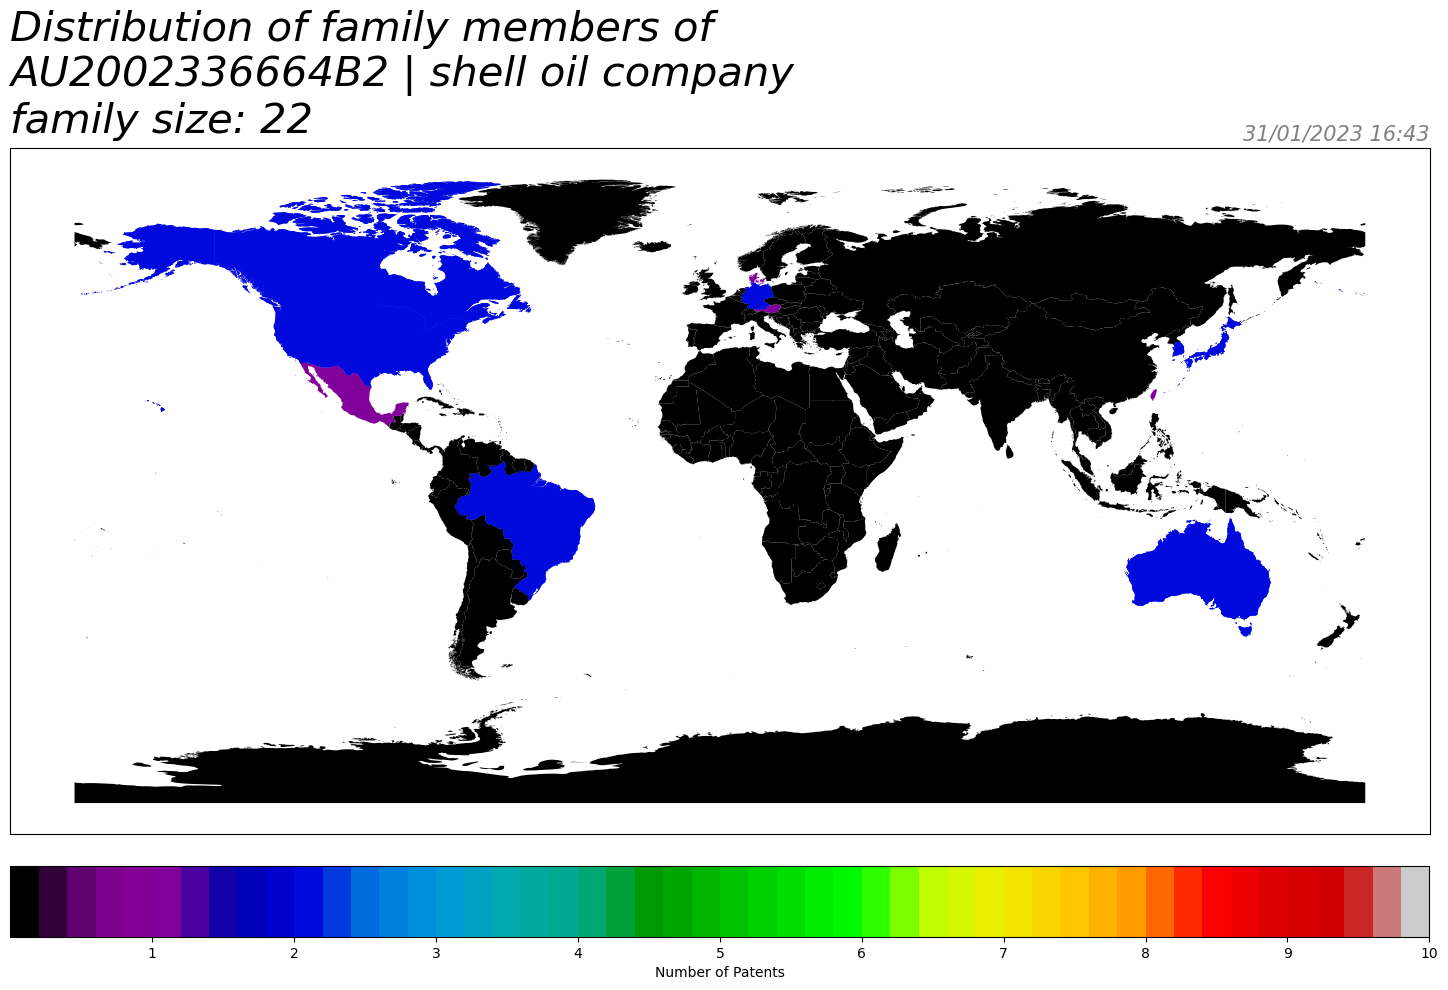

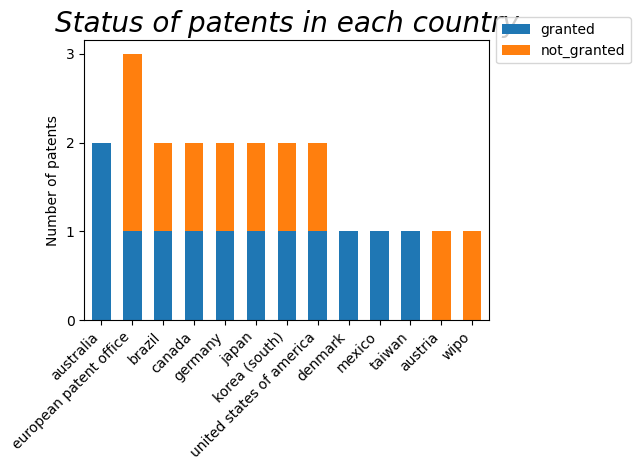

length of the family: 22 
the family: ['AU2002336664B2', 'AT299403T', 'AU2002336664C1', 'BR200213511A', 'BRPI0213511B1', 'CA2462215A1', 'CA2462215C', 'DE60205038D1', 'DE60205038T2', 'DK1467826T3', 'EP1467826A1', 'EP1467826B1', 'EP1467826B8', 'JP04509558B2', 'JP2005506902A', 'KR2004048428A', 'KR925129B1', 'MX2004003712A', 'TW564192B', 'US20040126190A1', 'US6951436B2', 'WO2003035290A1']
None
None


In [8]:

#plot for all patents (granted and not granted)
plot_worldmap_for_each_family(data_all_total)
